<a id='top'></a>

# Kolmogorov-Smirnov test

In this notebook we will illustrate the use of the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test) (K-S test) using functions from the [SciPy stats module](http://docs.scipy.org/doc/scipy/reference/stats.html). In particular, we will look at the influence of the sample size.

## Table of contents

[Preamble](#Preamble)

[Data setup](#Data-setup)

[Odds and ends](#Odds-and-ends)

## Preamble

The first step is to setup the computational environment. For that we will start by importing the major packages needed for this notebook:

In [1]:
import sys
import math
import numpy as np
import scipy as sp
import matplotlib as mpl
import pandas as pd

Let us check the versions being used:

In [2]:
print('System: {}'.format(sys.version))
for package in (np, sp, mpl, pd):
    print('Package: {} {}'.format(package.__name__, package.__version__))

System: 3.5.1 |Anaconda 4.0.0 (32-bit)| (default, Dec  7 2015, 11:17:45) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Package: numpy 1.10.4
Package: scipy 0.17.0
Package: matplotlib 1.5.1
Package: pandas 0.18.0


Now, we import the stats module from the scipy package plus additional modules/packages required by this notebook:

In [3]:
from scipy import stats
import matplotlib.pyplot as plt

To make the plots visible inside the notebook, we need the following Jupyter "magic" command:

In [4]:
%matplotlib inline

Now we are ready to start exploring.

[Back to top](#top)

## Data setup

First of all, we will generate a normal random variable (RV) with mean 1.0 and standard deviation 0.1:

In [5]:
mean = 1.0
std = 0.1
rv = stats.norm(loc=mean, scale=std)

This is said to be a 'frozen' RV object since the location and scale parameters are given. Let us plot the probability density function (pdf) as well as the cumulative density function (cdf), between percentiles 0.001 and 0.999, to check the random variable:

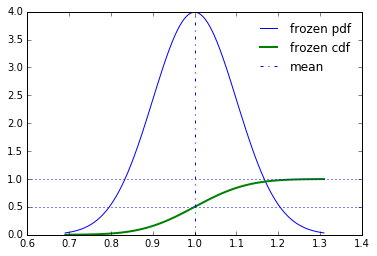

In [6]:
x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.pdf(x), label='frozen pdf')
ax.plot(x, rv.cdf(x), lw=2, label='frozen cdf')
ax.axhline(0.5, ls=':')
ax.axhline(1.0, ls=':')
ax.axvline(mean, ls='-.', label='mean')
ax.legend(loc='best', frameon=False)
plt.show()

Now we will generate three random samples, with sizes 50, 500 and 5000, and look at them in a histogram plot together with the normal pdf to see how they match:

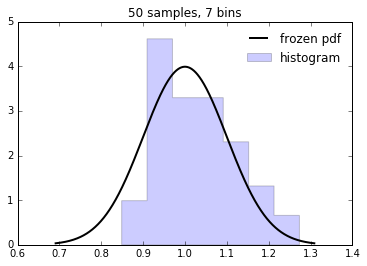

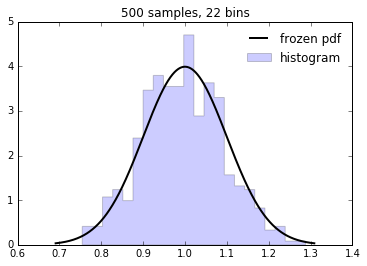

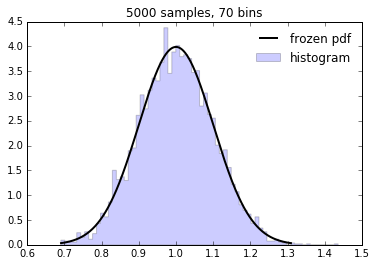

In [7]:
Nsamples = [50, 500, 5000]
ysamples = []
for N in Nsamples:
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
    y = rv.rvs(size=N)
    bins = int(math.sqrt(N))
    ysamples.append(y)
    ax.hist(y, bins=bins, normed=True, histtype='stepfilled', alpha=0.2, label='histogram')
    ax.legend(loc='best', frameon=False)
    ax.set_title('{} samples, {} bins'.format(N, bins))
    plt.show()

We used a different number of bins in the histogram plots in order to increase the discretization. As can be seen, the larger the size of the random sample, the better it fits the normal pdf. Similarly, we can plot the random samples, after ordering them in ascending order, together with the normal cdf:

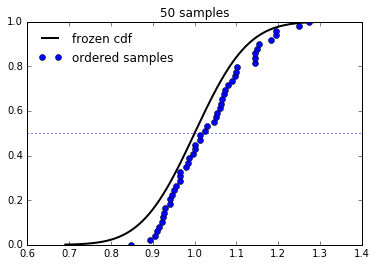

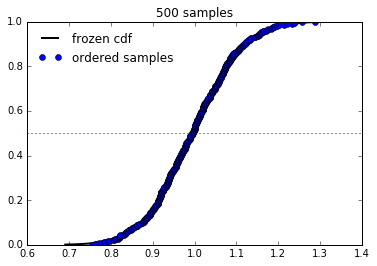

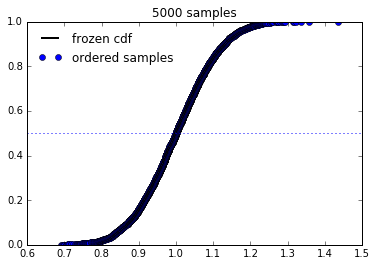

In [8]:
for N,y in zip(Nsamples, ysamples):
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, rv.cdf(x), 'k-', lw=2, label='frozen cdf')
    yn = np.sort(y)
    xn = np.linspace(0., 1., num=N)
    ax.plot(yn, xn, 'o', label='ordered samples')
    ax.axhline(0.5, ls=':')
    ax.legend(loc='best', frameon=False)
    ax.set_title('{} samples'.format(N))
    plt.show()

Interestingly, the larger the sample size the better it fits the normal cdf. But then again, this is what can be expected after seeing the histogram plots. Finally, let us compute the K-S test for goodness of fit:

In [9]:
for N,y in zip(Nsamples, ysamples):
    D, pvalue = stats.kstest(y, 'norm', args=(mean, std))
    print('{:4d} samples: D={}, pvalue={}'.format(N, D, pvalue))

  50 samples: D=0.1426959254569733, pvalue=0.23722503819385254
 500 samples: D=0.03781120094602142, pvalue=0.466932304621269
5000 samples: D=0.006811706447962751, pvalue=0.9744800641708968


It is curious to see that the highest p-value does not occur for the lowest D (statistic) value. In fact, it seems that, as the size of the sample increases, the p-value does not show a tendency to improve, despite the fact that both the histogram plot and the ordered sample plot seem to fit better the normal pdf and cdf, respectively.
For comparison, we will also compute the [Anderson-Darling test](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test) (A-D test), for data coming from a particular distribution, and, since we are using a normal random variable, the [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) (S-W test) for normality:

In [10]:
print('A-D test')
for N,y in zip(Nsamples, ysamples):
    A2, critical_values, significance_level = stats.anderson(y)
    print('{:4d} samples: A2={}'.format(N, A2), critical_values, significance_level)
print()
print('S-W test')
for N,y in zip(Nsamples, ysamples):
    W, pvalue = stats.shapiro(y)
    print('{:4d} samples: W={}, pvalue={}'.format(N, W, pvalue))

A-D test
  50 samples: A2=0.4991894257259446 [ 0.538  0.613  0.736  0.858  1.021] [ 15.   10.    5.    2.5   1. ]
 500 samples: A2=0.24351828239872475 [ 0.571  0.651  0.781  0.911  1.083] [ 15.   10.    5.    2.5   1. ]
5000 samples: A2=0.28162150985281187 [ 0.576  0.655  0.786  0.917  1.091] [ 15.   10.    5.    2.5   1. ]

S-W test
  50 samples: W=0.9688406586647034, pvalue=0.20755213499069214
 500 samples: W=0.9970875978469849, pvalue=0.5196529626846313
5000 samples: W=0.9995322227478027, pvalue=0.266998827457428


Both tests show that ... (to be concluded!)

[Back to top](#top)

## Odds and ends

This notebook was created by Paulo Xavier Candeias.

[Back to top](#top)